# Produce multiple global pathways

Generate a complete set of global pathways from the complete set of commitments.

### Inputs
Country level, total GHG excl LULUCF emissions up to 2050


### Outputs
Lots of global total GHG excl LULUCF emissions pathway/pathways for commitments before a given date

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import os
from datetime import datetime
import itertools
import logging

import scmdata.database
from tqdm.autonotebook import tqdm

from ndcs.constants import PROCESSED_DATA_DIR, RAW_DATA_DIR, NDC_TARGET_RELEASE
from ndcs.pathways import NDCCruncher


<IPython.core.display.Javascript object>

/home/jared/miniconda3/envs/ndc-realisations-2021/lib/python3.9/site-packages/scmdata/database.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


<IPython.core.display.Javascript object>

In [4]:
RAW_COUNTRY_DATABASE_DIR = os.path.join(
    RAW_DATA_DIR, "country_emissions", NDC_TARGET_RELEASE
)
EXTENDED_COUNTRY_DATABASE_DIR = os.path.join(
    PROCESSED_DATA_DIR, "country_emissions", NDC_TARGET_RELEASE
)
GLOBAL_DATABASE_DIR = os.path.join(
    PROCESSED_DATA_DIR, "global_emissions_pathways", NDC_TARGET_RELEASE
)
BASELINE_SCENARIO = "SSP1BL"  # Used to fill countries which have not reported yet

<IPython.core.display.Javascript object>

In [5]:
raw_country_db = scmdata.database.ScmDatabase(
    RAW_COUNTRY_DATABASE_DIR, levels=("region", "variable")
)
raw_country_db

<scmdata.database.SCMDatabase (root_dir: /home/jared/code/cr/ndc-realisations-2021/src/ndcs/../../data/raw/country_emissions/12Nov2021a_CR, levels: ('region', 'variable'))>

<IPython.core.display.Javascript object>

In [6]:
extended_country_db = scmdata.database.ScmDatabase(
    EXTENDED_COUNTRY_DATABASE_DIR, levels=("region", "variable")
)
extended_country_db

<scmdata.database.SCMDatabase (root_dir: /home/jared/code/cr/ndc-realisations-2021/src/ndcs/../../data/processed/country_emissions/12Nov2021a_CR, levels: ('region', 'variable'))>

<IPython.core.display.Javascript object>

In [7]:
global_db = scmdata.database.ScmDatabase(
    GLOBAL_DATABASE_DIR,
    levels=(
        "ambition",
        "conditionality",
        "country_extension",
        "exclude_hot_air",
        "pathway_id",
        "global_extension",
    ),
)
global_db

<scmdata.database.SCMDatabase (root_dir: /home/jared/code/cr/ndc-realisations-2021/src/ndcs/../../data/processed/global_emissions_pathways/12Nov2021a_CR, levels: ('ambition', 'conditionality', 'country_extension', 'exclude_hot_air', 'pathway_id', 'global_extension'))>

<IPython.core.display.Javascript object>

In [8]:
# Start fresh
global_db.delete()

<IPython.core.display.Javascript object>

In [9]:
raw_country_emms = extended_country_db.load().filter(
    country_extension="SSP5BL", keep=False
)
len(raw_country_emms.get_unique_meta("region"))

Loading files:   0%|          | 0/990 [00:00<?, ?it/s]

198

<IPython.core.display.Javascript object>

In [10]:
raw_country_emms.get_unique_meta("country_extension")

['SSP1BL', 'constant', '2030', 'rate']

<IPython.core.display.Javascript object>

In [11]:
# raw_country_emms = raw_country_emms.filter(
#     country_extension=["SSP1BL", "2030"], conditionality=["C", "U"]
# )

<IPython.core.display.Javascript object>

In [12]:
# 24 combintations in total
raw_country_emms.meta[
    ["ambition", "country_extension", "conditionality"]
].drop_duplicates().reset_index(drop=True)

,ambition,country_extension,conditionality
0,high,SSP1BL,C
1,high,SSP1BL,R
2,high,SSP1BL,U
3,low,SSP1BL,C
4,low,SSP1BL,R
5,low,SSP1BL,U
6,high,constant,C
7,high,constant,R
8,high,constant,U
9,low,constant,C


<IPython.core.display.Javascript object>

In [13]:
baseline_country_emms = raw_country_db.load(variable="Emissions|Total GHG").filter(
    scenario=BASELINE_SCENARIO
)
len(baseline_country_emms.get_unique_meta("region"))

Loading files:   0%|          | 0/198 [00:00<?, ?it/s]

198

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='time', ylabel='Mt CO2/yr'>

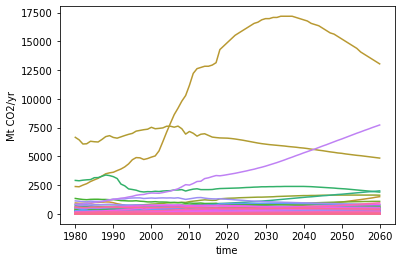

<IPython.core.display.Javascript object>

In [14]:
baseline_country_emms.lineplot(hue="region", legend=False)

In [15]:
# We have to scale the SSP1BL emissions to match the countries historical values
# This is also done in 220
SCALE_YEAR = 2015

baseline_adjusted_emms = []


targets = raw_country_emms.filter(
    scenario="HighNDC",
    conditionality="C",
    country_extension="SSP1BL",
    exclude_hot_air="include",
    year=SCALE_YEAR,
)
for r in baseline_country_emms.get_unique_meta("region"):
    region_emms = baseline_country_emms.filter(region=r)

    scale_factor = (
        targets.filter(region=r).values.squeeze()
        / region_emms.filter(year=SCALE_YEAR).values.squeeze()
    )

    baseline_adjusted_emms.append(region_emms * scale_factor)
baseline_adjusted_emms = scmdata.run_append(baseline_adjusted_emms)

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='time', ylabel='Mt CO2/yr'>

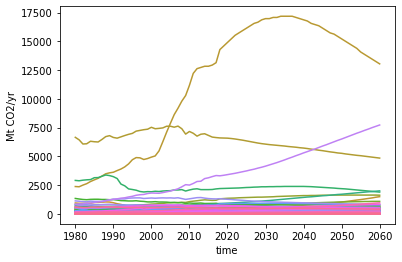

<IPython.core.display.Javascript object>

In [16]:
baseline_adjusted_emms.lineplot(hue="region", legend=False)

In [17]:
raw_country_emms.filter(
    scenario="HighNDC",
    conditionality="C",
    country_extension="SSP1BL",
    exclude_hot_air="exclude",
    year=2015,
).timeseries().sum()

time
2015-01-01    48223.28657
dtype: float64

<IPython.core.display.Javascript object>

In [18]:
baseline_adjusted_emms.filter(scenario=BASELINE_SCENARIO, year=2015).timeseries().sum()

time
2015-01-01    48223.28657
dtype: float64

<IPython.core.display.Javascript object>

In [19]:
raw_country_emms

<ScmRun (timeseries: 18992, timepoints: 61)>
Time:
	Start: 1990-01-01T00:00:00
	End: 2050-01-01T00:00:00
Meta:
	      ambition conditionality country_extension exclude_hot_air  last_provided_year          model region        scenario submission_date        unit                                 variable
	0         high              C            SSP1BL         exclude                2030  NDC Factsheet    TUV  HighInitialNDC       4/22/2016  Mt CO2 /yr  Emissions|Total GHG excl. LULUCF|SSP1BL
	1         high              R            SSP1BL         exclude                2030  NDC Factsheet    TUV  HighInitialNDC       4/22/2016  Mt CO2 /yr  Emissions|Total GHG excl. LULUCF|SSP1BL
	2         high              U            SSP1BL         exclude                2030  NDC Factsheet    TUV  HighInitialNDC       4/22/2016  Mt CO2 /yr  Emissions|Total GHG excl. LULUCF|SSP1BL
	3          low              C            SSP1BL         exclude                2030  NDC Factsheet    TUV   LowInitialND

<IPython.core.display.Javascript object>

In [20]:
country_emms = raw_country_emms.copy()

<IPython.core.display.Javascript object>

In [21]:
# Override some submission dates
update_dates = (
    ("ZZA", True, "7/18/2013"),
    ("ZZB", True, "7/18/2013"),
    ("LBY", True, "7/18/2013"),
    ("ZZA", False, "10/4/2019"),
    ("ZZB", False, "4/30/2018"),
)

for region, is_initial, date in update_dates:
    scenario = (
        ["HighInitialNDC", "LowInitialNDC"] if is_initial else ["HighNDC", "LowNDC"]
    )
    subset = country_emms.filter(region=region, scenario=scenario)
    subset["submission_date"] = date

    country_emms = scmdata.run_append(
        [country_emms.filter(region=region, scenario=scenario, keep=False), subset]
    )

<IPython.core.display.Javascript object>

In [22]:
# Drop the duplicated timeseries for countries which have not reported an updated NDC yet
country_emms = country_emms.filter(submission_date="NOT YET", keep=False)

<IPython.core.display.Javascript object>

In [23]:
len(country_emms.filter(variable="Emissions|Total GHG excl. LULUCF|SSP1BL"))

4244

<IPython.core.display.Javascript object>

In [24]:
raw_country_emms.filter(region="IND").get_unique_meta("submission_date")

['10/2/2016', '11/1/2021']

<IPython.core.display.Javascript object>

# Preprocessing
* Convert SubmissionDate to something we can filter by

In [25]:
# Dates are in american format (MM/DD/YYYY)
country_emms["submission_date"] = [
    datetime.strptime(d, "%m/%d/%Y").date() for d in country_emms["submission_date"]
]
country_emms = country_emms.resample("AS").filter(year=range(2010, 2051))

<IPython.core.display.Javascript object>

In [26]:
baseline_adjusted_emms = baseline_adjusted_emms.resample("AS").filter(
    year=range(2010, 2051)
)

<IPython.core.display.Javascript object>

In [27]:
country_emms["model"] = "NDC Factsheet"
country_emms["model_version"] = NDC_TARGET_RELEASE

<IPython.core.display.Javascript object>

# Merge available scenarios

Given a set of submitted NDCs, merge to form a single global path. If a country has not yet submitted, add emissions from SSP1 or SSP5

In [28]:
%pdb off

Automatic pdb calling has been turned OFF


<IPython.core.display.Javascript object>

In [29]:
def process_all_ndcs(conditionality, ambition, country_extension, exclude_hot_air):
    cruncher = NDCCruncher(
        global_db,
        country_emms,
        baseline_adjusted_emms,
        conditionality,
        ambition,
        country_extension,
        exclude_hot_air,
    )
    cruncher.crunch()

<IPython.core.display.Javascript object>

In [30]:
options = list(
    itertools.product(
        country_emms.get_unique_meta("conditionality"),
        country_emms.get_unique_meta("ambition"),
        country_emms.get_unique_meta("country_extension"),
        country_emms.get_unique_meta("exclude_hot_air"),
    )
)
options

[('C', 'high', 'SSP1BL', 'exclude'),
 ('C', 'high', 'SSP1BL', 'include'),
 ('C', 'high', 'constant', 'exclude'),
 ('C', 'high', 'constant', 'include'),
 ('C', 'high', '2030', 'exclude'),
 ('C', 'high', '2030', 'include'),
 ('C', 'high', 'rate', 'exclude'),
 ('C', 'high', 'rate', 'include'),
 ('C', 'low', 'SSP1BL', 'exclude'),
 ('C', 'low', 'SSP1BL', 'include'),
 ('C', 'low', 'constant', 'exclude'),
 ('C', 'low', 'constant', 'include'),
 ('C', 'low', '2030', 'exclude'),
 ('C', 'low', '2030', 'include'),
 ('C', 'low', 'rate', 'exclude'),
 ('C', 'low', 'rate', 'include'),
 ('R', 'high', 'SSP1BL', 'exclude'),
 ('R', 'high', 'SSP1BL', 'include'),
 ('R', 'high', 'constant', 'exclude'),
 ('R', 'high', 'constant', 'include'),
 ('R', 'high', '2030', 'exclude'),
 ('R', 'high', '2030', 'include'),
 ('R', 'high', 'rate', 'exclude'),
 ('R', 'high', 'rate', 'include'),
 ('R', 'low', 'SSP1BL', 'exclude'),
 ('R', 'low', 'SSP1BL', 'include'),
 ('R', 'low', 'constant', 'exclude'),
 ('R', 'low', 'constan

<IPython.core.display.Javascript object>

In [31]:
logger = logging.getLogger("nb")

<IPython.core.display.Javascript object>

In [32]:
from concurrent.futures import as_completed, ProcessPoolExecutor
import time

pool = ProcessPoolExecutor(
    max_workers=16,
)
futures = [pool.submit(process_all_ndcs, *a) for a in options]

logger.info("Waiting for jobs to complete")
for i, future in tqdm(
    enumerate(as_completed(futures)), total=len(futures), desc="options"
):
    if future.exception() is not None:
        time.sleep(2)  # let buffer flush out
        print(
            "One of the processes failed, see error below (was something "
            "unable to be pickled?)"
        )
        raise future.exception()

res = []
logger.info("Collecting results")
for i, future in enumerate(futures):
    try:
        res.append(future.result())
    except Exception as exc:  # pylint:disable=broad-except
        res.append(exc)

options:   0%|          | 0/48 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [33]:
global_emms = global_db.load()

Loading files:   0%|          | 0/16976 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [34]:
global_emms.head()

time                                                                                                                                                                                                                                                   2010-01-01  \
ambition conditionality country_extension date       exclude_hot_air global_extension last_country model         pathway_id   pathway_num pathway_num_today region scenario                             unit       variable                                         
high     R              2030              2021-08-02 exclude         n/a              COG          NDC Factsheet 2021-08-02_1 309         1                 World  2021-08-02_1__high__R__2030__exclude Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.555590   
                                          2021-10-10 exclude         n/a              PSE          NDC Factsheet 2021-10-10_1 325         1                 World  2021-10-10_1__high__R__2030__exclude Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.555590   
                                          2021-04-16 exclude         n/a              MKD          NDC Factsheet 2021-04-16_1 277         1                 World  2021-04-16_1__high__R__2030__exclude Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.555590   
                                          2018-11-30 exclude         n/a              SYR          NDC Factsheet 2018-11-30_1 193         1                 World  2018-11-30_1__high__R__2030__exclude Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45113.146990   
                                          2020-12-09 exclude         n/a              NPL          NDC Factsheet 2020-12-09_3 219         3                 World  2020-12-09_3__high__R__2030__exclude Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45086.288422   

time                                                                                                                                                                                                                                                   2011-01-01  \
ambition conditionality country_extension date       exclude_hot_air global_extension last_country model         pathway_id   pathway_num pathway_num_today region scenario                             unit       variable                                         
high     R              2030              2021-08-02 exclude         n/a              COG          NDC Factsheet 2021-08-02_1 309         1                 World  2021-08-02_1__high__R__2030__exclude Mt CO2 /yr Emissions|Total GHG excl. LULUCF  46428.064370   
                                          2021-10-10 exclude         n/a              PSE          NDC Factsheet 2021-10-10_1 325         1                 World  2021-10-10_1__high__R__2030__exclude Mt CO2 /yr Emissions|Total GHG excl. LULUCF  46428.064370   
                                          2021-04-16 exclude         n/a              MKD          NDC Factsheet 2021-04-16_1 277         1                 World  2021-04-16_1__high__R__2030__exclude Mt CO2 /yr Emissions|Total GHG excl. LULUCF  46428.064370   
                                          2018-11-30 exclude         n/a              SYR          NDC Factsheet 2018-11-30_1 193         1                 World  2018-11-30_1__high__R__2030__exclude Mt CO2 /yr Emissions|Total GHG excl. LULUCF  46470.336655   
                                          2020-12-09 exclude         n/a              NPL          NDC Factsheet 2020-12-09_3 219         3                 World  2020-12-09_3__high__R__2030__exclude Mt CO2 /yr Emissions|Total GHG excl. LULUCF  46429.675899   

time                                                                                                                                                                                                                                                   2012-01-01  \
ambition conditionality country_extension date       exclude_hot_air global_extensi

<IPython.core.display.Javascript object>

In [35]:
global_emms.filter(country_extension="SSP1BL").lineplot(
    hue="scenario", units="scenario", estimator=None
)

<AxesSubplot:xlabel='time', ylabel='Mt CO2 /yr'>

/home/jared/miniconda3/envs/ndc-realisations-2021/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 402x67543 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

<IPython.core.display.Javascript object>

In [36]:
pathways = global_emms.timeseries().sort_index(level="pathway_id")
pathways

time                                                                                                                                                                                                                                                       2010-01-01  \
ambition conditionality country_extension date       exclude_hot_air global_extension last_country model         pathway_id   pathway_num pathway_num_today region scenario                                 unit       variable                                         
high     C              2030              2013-07-18 exclude         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  2013-07-18_1__high__C__2030__exclude     Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443   
                                                     include         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  2013-07-18_1__high__C__2030__include     Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443   
                        SSP1BL            2013-07-18 exclude         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  2013-07-18_1__high__C__SSP1BL__exclude   Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443   
                                                     include         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  2013-07-18_1__high__C__SSP1BL__include   Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443   
                        constant          2013-07-18 exclude         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  2013-07-18_1__high__C__constant__exclude Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443   
                                                     include         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  2013-07-18_1__high__C__constant__include Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443   
                        rate              2013-07-18 exclude         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  2013-07-18_1__high__C__rate__exclude     Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443   
                                                     include         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  2013-07-18_1__high__C__rate__include     Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443   
         R              2030              2013-07-18 exclude         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  2013-07-18_1__high__R__2030__exclude     Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443   
                                                     include         n/a              LBY          NDC Factsheet 2013-07-18_1 1           1                 World  2013-07-18_1__high__R__2030__include     Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45328.738443   
...                                                                                                                                                                                                                                                               ...   
low      R              rate              2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  2021-11-09_1__low__R__rate__exclude      Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.555590   
                                                     include         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  2021-11-09_1__low__R__rate__include      Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.555590   
         U              2

<IPython.core.display.Javascript object>

In [37]:
latest_pathway = max(global_emms.get_unique_meta("pathway_num"))
latest_pathway

354

<IPython.core.display.Javascript object>

In [38]:
global_emms.filter(pathway_num=latest_pathway).timeseries()

time                                                                                                                                                                                                                                                      2010-01-01  \
ambition conditionality country_extension date       exclude_hot_air global_extension last_country model         pathway_id   pathway_num pathway_num_today region scenario                                 unit       variable                                        
high     R              2030              2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  2021-11-09_1__high__R__2030__exclude     Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559   
                                                     include         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  2021-11-09_1__high__R__2030__include     Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559   
                        SSP1BL            2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  2021-11-09_1__high__R__SSP1BL__exclude   Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559   
                                                     include         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  2021-11-09_1__high__R__SSP1BL__include   Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559   
                        rate              2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  2021-11-09_1__high__R__rate__exclude     Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559   
                                                     include         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  2021-11-09_1__high__R__rate__include     Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559   
                        constant          2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  2021-11-09_1__high__R__constant__exclude Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559   
                                                     include         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  2021-11-09_1__high__R__constant__include Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559   
         C              2030              2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  2021-11-09_1__high__C__2030__exclude     Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559   
                                                     include         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  2021-11-09_1__high__C__2030__include     Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559   
                        SSP1BL            2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  2021-11-09_1__high__C__SSP1BL__exclude   Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559   
                                                     include         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  2021-11-09_1__high__C__SSP1BL__include   Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559   
                        rate              2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1 354         1                 World  2021-11-09_1__high__C__rate__exclude     Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.55559   
                                        

<IPython.core.display.Javascript object>